# Real Estate Price Prediction - ML Models

This notebook builds machine learning models to predict real estate prices using the Immovlan dataset.

## Table of Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Data Cleaning](#2-data-cleaning)
3. [Preprocessing Functions](#3-preprocessing-functions)
4. [Run Preprocessing Pipeline](#4-run-preprocessing-pipeline)
5. [Model 1: Linear Regression](#5-model-1-linear-regression)
6. [Model 2: Decision Tree](#6-model-2-decision-tree)
7. [Model 3: Random Forest](#7-model-3-random-forest)
8. [Model 4: XGBoost](#8-model-4-xgboost)
9. [Model Comparison](#9-model-comparison)

---
## 1. Setup & Data Loading

In [331]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Load data
df = pd.read_csv("immovlan_cleaned_file.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset shape: (16309, 33)

Columns: ['url', 'Property ID', 'Price', 'State of the property', 'Availability', 'Number of bedrooms', 'Livable surface', 'Furnished', 'Attic', 'Garage', 'Number of garages', 'Kitchen equipment', 'Kitchen type', 'Number of bathrooms', 'Number of showers', 'Number of toilets', 'Type of heating', 'Type of glazing', 'Elevator', 'Number of facades', 'Garden', 'Surface garden', 'Terrace', 'Surface terrace', 'Total land surface', 'Swimming pool', 'type', 'postal_code', 'city', 'Region', 'province', 'price_per_sqm', 'Price_per_sqm_land']


---
## 2. Data Cleaning

In [332]:
# Drop columns that are not needed for the model
# Note: Dropped 'price_per_sqm' to avoid data leakage (it reveals price indirectly)
columns_to_drop = [
    'url', 'Property ID', 'State of the property', 'Availability',
    'Livable surface', 'Furnished', 'Attic', 'Number of garages',
    'Kitchen equipment', 'Kitchen type', 'Number of showers',
    'Type of heating', 'Type of glazing', 'Number of facades',
    'Surface garden', 'Terrace', 'Surface terrace', 'Total land surface',
    'city', 'province', 'price_per_sqm', 'Price_per_sqm_land'
]

df_clean = df.drop(columns_to_drop, axis='columns')
print(f"Columns after dropping: {df_clean.columns.tolist()}")

Columns after dropping: ['Price', 'Number of bedrooms', 'Garage', 'Number of bathrooms', 'Number of toilets', 'Elevator', 'Garden', 'Swimming pool', 'type', 'postal_code', 'Region']


In [333]:
# Drop rows where Price is missing (only ~3.5% of data)
df_clean = df_clean.dropna(subset=['Price'])

# Drop rows with unrealistic values (>20 bedrooms, bathrooms, or toilets)
df_clean = df_clean[
    ~((df_clean["Number of bedrooms"] > 20) |
      (df_clean["Number of bathrooms"] > 20) |
      (df_clean["Number of toilets"] > 20))
]

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"\nMissing values:\n{df_clean.isnull().sum()}")

Dataset shape after cleaning: (15717, 11)

Missing values:
Price                      0
Number of bedrooms      2170
Garage                  8891
Number of bathrooms     4047
Number of toilets       5960
Elevator                5223
Garden                  3287
Swimming pool          11961
type                       0
postal_code                0
Region                     0
dtype: int64


---
## 3. Preprocessing Functions

### Preprocessing Strategy:
1. **Split data** into train/val/test (60/20/20)
2. **Target encoding** for categorical columns (type, Region)
3. **Median imputation** for numeric columns
4. **Outlier handling** based on skewness
5. **Standardization** for numeric columns
6. **KNN imputation** for binary columns with moderate missing (Elevator, Garden)
7. **Zero imputation** for binary columns with high missing (Garage, Swimming pool)

In [334]:
def split_60_20_20(df, target, random_state=42):
    """
    Splits the dataset into:
    - 60% training
    - 20% validation
    - 20% testing
    """
    X = df.drop(target, axis=1)
    y = df[target]

    # Step 1: Train+Val vs Test (80% / 20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.20, random_state=random_state
    )

    # Step 2: Train vs Val (75% / 25% of the 80%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [335]:
def target_encode(X_train, X_val, X_test, y_train, categorical_cols):
    """
    Target encoding for categorical columns.
    Replaces categories with mean price from training data.
    """
    if not categorical_cols:
        return X_train, X_val, X_test, None
    
    enc = TargetEncoder(smooth="auto", target_type="continuous", random_state=42)
    
    X_train[categorical_cols] = enc.fit_transform(X_train[categorical_cols], y_train)
    X_val[categorical_cols] = enc.transform(X_val[categorical_cols])
    X_test[categorical_cols] = enc.transform(X_test[categorical_cols])
    
    return X_train, X_val, X_test, enc

In [336]:
def impute_numeric(X_train, X_val, X_test, numeric_cols):
    """
    Impute missing values in numeric columns using median.
    """
    if not numeric_cols:
        return X_train, X_val, X_test, None
    
    imputer = SimpleImputer(strategy='median')

    X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
    X_val[numeric_cols] = imputer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

    return X_train, X_val, X_test, imputer

In [337]:
# Outlier handling functions

def analyze_skewness(df, cols):
    """
    Analyze skewness to determine outlier handling method.
    - Very skewed (|skew| > 1): log-sigma method
    - Moderately skewed (|skew| > 0.5): quantile capping
    - Normal distribution: z-score capping
    """
    skew_report = {}
    for col in cols:
        s = df[col].skew()
        if abs(s) > 1:
            skew_report[col] = "log_sigma"
        elif abs(s) > 0.5:
            skew_report[col] = "quantile"
        else:
            skew_report[col] = "zscore"
    return skew_report


def log_sigma_cap(s):
    """Cap outliers using log transformation and 3-sigma rule."""
    log_s = np.log1p(s)
    mean, std = log_s.mean(), log_s.std()
    lower = mean - 3 * std
    upper = mean + 3 * std
    return np.expm1(np.clip(log_s, lower, upper))


def quantile_cap(s, low_q=0.01, high_q=0.99):
    """Cap outliers using quantile boundaries."""
    return s.clip(s.quantile(low_q), s.quantile(high_q))


def zscore_cap(s, z=3):
    """Cap outliers using z-score boundaries."""
    mean, std = s.mean(), s.std()
    lower = mean - z * std
    upper = mean + z * std
    return s.clip(lower, upper)


def handle_outliers(X_train, X_val, X_test, numeric_cols):
    """
    Handle outliers based on column skewness.
    """
    if not numeric_cols:
        return X_train, X_val, X_test
    
    skewness = analyze_skewness(X_train, numeric_cols)

    for col, method in skewness.items():
        if method == "log_sigma":
            X_train[col] = log_sigma_cap(X_train[col])
            X_val[col] = log_sigma_cap(X_val[col])
            X_test[col] = log_sigma_cap(X_test[col])
        elif method == "quantile":
            X_train[col] = quantile_cap(X_train[col])
            X_val[col] = quantile_cap(X_val[col])
            X_test[col] = quantile_cap(X_test[col])
        else:  # zscore
            X_train[col] = zscore_cap(X_train[col])
            X_val[col] = zscore_cap(X_val[col])
            X_test[col] = zscore_cap(X_test[col])

    return X_train, X_val, X_test

In [338]:
def scale_numeric(X_train, X_val, X_test, numeric_cols):
    """
    Standardize numeric columns to have mean=0 and std=1.
    """
    if not numeric_cols:
        return X_train, X_val, X_test, None
    
    scaler = StandardScaler()

    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_val, X_test, scaler

In [339]:
def knn_impute_binary(X_train, X_val, X_test, binary_cols, n_neighbors=5):
    """
    KNN imputation for binary columns with moderate missing values.
    Results are rounded to ensure binary (0/1) output.
    """
    if not binary_cols:
        return X_train, X_val, X_test, None
    
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)

    X_train[binary_cols] = knn_imputer.fit_transform(X_train[binary_cols])
    X_val[binary_cols] = knn_imputer.transform(X_val[binary_cols])
    X_test[binary_cols] = knn_imputer.transform(X_test[binary_cols])

    # Round to ensure strictly 0/1 values
    for col in binary_cols:
        X_train[col] = X_train[col].round()
        X_val[col] = X_val[col].round()
        X_test[col] = X_test[col].round()

    return X_train, X_val, X_test, knn_imputer

In [340]:
def impute_zero(X_train, X_val, X_test, binary_cols):
    """
    Impute missing values with 0 for binary columns.
    Interpretation: garage=0 → no garage; swimming pool=0 → no pool.
    """
    if not binary_cols:
        return X_train, X_val, X_test
    
    for col in binary_cols:
        if col in X_train.columns:
            X_train[col] = X_train[col].fillna(0)
            X_val[col] = X_val[col].fillna(0)
            X_test[col] = X_test[col].fillna(0)

    return X_train, X_val, X_test

In [ ]:
def preprocess(df, target, numeric_cols, categorical_cols=[], binary_cols_knn=[], binary_cols_zero=[]):
    """
    Full preprocessing pipeline.
    Returns all fitted objects needed for predictions.

    Parameters:
        handle_outliers_flag: If True, apply outlier handling (use for Linear Regression)
                              If False, skip outlier handling (use for other models)
    """
    
    # 1. Split
    X_train, X_val, X_test, y_train, y_val, y_test = split_60_20_20(df, target, random_state=42)
    
    # 2. Target encoding
    target_encoder = None
    if categorical_cols:
        X_train, X_val, X_test, target_encoder = target_encode(X_train, X_val, X_test, y_train, categorical_cols)
    
    # 3. Numeric imputation
    X_train, X_val, X_test, numeric_imputer = impute_numeric(X_train, X_val, X_test, numeric_cols)
    
    # 4. Outlier handling
    X_train, X_val, X_test = handle_outliers(X_train, X_val, X_test, numeric_cols)
        
    # 5. Scaling
    X_train, X_val, X_test, scaler = scale_numeric(X_train, X_val, X_test, numeric_cols)
    
    # 6. KNN imputation for binary columns
    knn_imputer = None
    if binary_cols_knn:
        X_train, X_val, X_test, knn_imputer = knn_impute_binary(X_train, X_val, X_test, binary_cols_knn)
    
    # 7. Zero imputation for binary columns
    if binary_cols_zero:
        X_train, X_val, X_test = impute_zero(X_train, X_val, X_test, binary_cols_zero)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, target_encoder, numeric_imputer, knn_imputer

---
## 4. Run Preprocessing Pipeline

In [342]:
# Define column types
TARGET = 'Price'
NUMERIC_COLS = ['Number of bedrooms', 'Number of bathrooms', 'Number of toilets']
CATEGORICAL_COLS = ['type', 'Region']
BINARY_COLS_KNN = ['Elevator', 'Garden']
BINARY_COLS_ZERO = ['Garage', 'Swimming pool']

# Run preprocessing
X_train, X_val, X_test, y_train, y_val, y_test, scaler, target_encoder, numeric_imputer, knn_imputer = preprocess(
    df=df_clean,
    target=TARGET,
    numeric_cols=NUMERIC_COLS,
    categorical_cols=CATEGORICAL_COLS,
    binary_cols_knn=BINARY_COLS_KNN,
    binary_cols_zero=BINARY_COLS_ZERO
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures ({X_train.shape[1]}): {X_train.columns.tolist()}")

Training set: 9429 samples
Validation set: 3144 samples
Test set: 3144 samples

Features (10): ['Number of bedrooms', 'Garage', 'Number of bathrooms', 'Number of toilets', 'Elevator', 'Garden', 'Swimming pool', 'type', 'postal_code', 'Region']


In [343]:
# Helper function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    """
    Evaluate a model on training and validation sets.
    Returns a dictionary with all metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Train R²': r2_score(y_train, y_train_pred),
        'Val R²': r2_score(y_val, y_val_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Val RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred)
    }
    
    # Print results
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    print(f"\nTRAIN RESULTS")
    print(f"  R²:   {metrics['Train R²']:.4f}")
    print(f"  RMSE: €{metrics['Train RMSE']:,.0f}")
    print(f"  MAE:  €{metrics['Train MAE']:,.0f}")
    print(f"\nVALIDATION RESULTS")
    print(f"  R²:   {metrics['Val R²']:.4f}")
    print(f"  RMSE: €{metrics['Val RMSE']:,.0f}")
    print(f"  MAE:  €{metrics['Val MAE']:,.0f}")
    
    # Check for overfitting
    r2_gap = metrics['Train R²'] - metrics['Val R²']
    if r2_gap > 0.15:
        print(f"\n⚠️ Warning: Overfitting detected (R² gap: {r2_gap:.3f})")
    elif r2_gap > 0.05:
        print(f"\n⚡ Mild overfitting (R² gap: {r2_gap:.3f})")
    else:
        print(f"\n✓ Good generalization (R² gap: {r2_gap:.3f})")
    
    return metrics

---
## 5. Model 1: Linear Regression

In [344]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate
lr_metrics = evaluate_model(lr_model, X_train, y_train, X_val, y_val, "Linear Regression")


Linear Regression Results

TRAIN RESULTS
  R²:   0.3329
  RMSE: €249,138
  MAE:  €121,741

VALIDATION RESULTS
  R²:   0.2088
  RMSE: €362,042
  MAE:  €129,860

⚡ Mild overfitting (R² gap: 0.124)


---
## 6. Model 2: Decision Tree

In [345]:
# Train Decision Tree
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate
dt_metrics = evaluate_model(dt_model, X_train, y_train, X_val, y_val, "Decision Tree")


Decision Tree Results

TRAIN RESULTS
  R²:   0.9906
  RMSE: €29,613
  MAE:  €8,296

VALIDATION RESULTS
  R²:   0.3909
  RMSE: €317,655
  MAE:  €132,620

⚠️ Warning: Overfitting detected (R² gap: 0.600)


**Summary (Decision Tree):**
- Very high train R² but lower validation R² → **Overfitting**
- The model memorizes training data instead of learning patterns
- Need to constrain the tree (max_depth, min_samples_leaf)

---
## 7. Model 3: Random Forest

In [346]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Evaluate
rf_metrics = evaluate_model(rf_model, X_train, y_train, X_val, y_val, "Random Forest")


Random Forest Results

TRAIN RESULTS
  R²:   0.8981
  RMSE: €97,352
  MAE:  €42,362

VALIDATION RESULTS
  R²:   0.4767
  RMSE: €294,437
  MAE:  €104,386

⚠️ Warning: Overfitting detected (R² gap: 0.421)


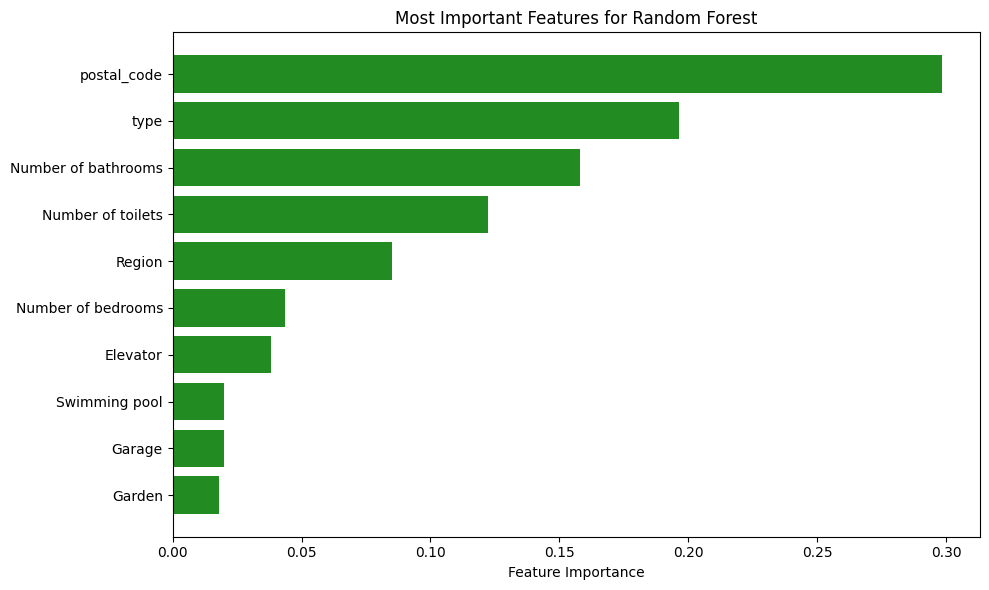

In [347]:
# Feature importance for Random Forest
importances = rf_model.feature_importances_ 
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:15], sorted_importances[:15], color='forestgreen')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Most Important Features for Random Forest")
plt.tight_layout()
plt.show()

---
## 8. Model 4: XGBoost

In [348]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_val, y_val, "XGBoost")


XGBoost Results

TRAIN RESULTS
  R²:   0.7328
  RMSE: €157,672
  MAE:  €89,171

VALIDATION RESULTS
  R²:   0.5382
  RMSE: €276,602
  MAE:  €109,451

⚠️ Warning: Overfitting detected (R² gap: 0.195)


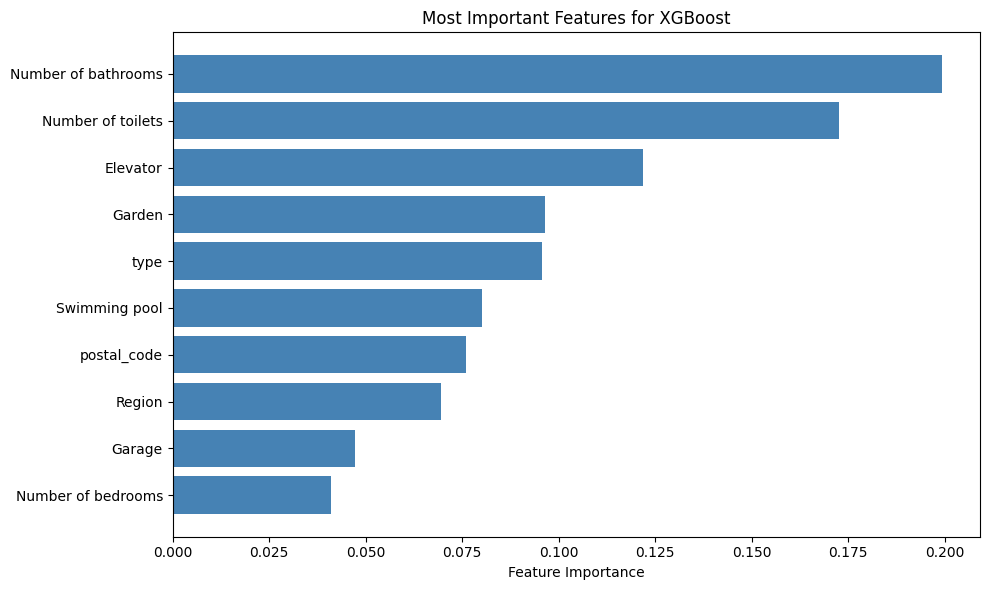

In [349]:
# Feature importance for XGBoost
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:15], sorted_importances[:15], color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Most Important Features for XGBoost")
plt.tight_layout()
plt.show()

---
## 9. Model Comparison

In [350]:
# Create comparison dataframe
all_metrics = [lr_metrics, dt_metrics, rf_metrics, xgb_metrics]
comparison_df = pd.DataFrame(all_metrics).set_index('Model')


# Overfitting indicator
comparison_df['R² Gap'] = comparison_df['Train R²'] - comparison_df['Val R²']
comparison_df['Overfitting?'] = comparison_df['R² Gap'].apply(
    lambda x: 'Yes' if x > 0.15 else ('Mild' if x > 0.05 else 'No'))

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.round(4).to_string())



MODEL COMPARISON
                   Train R²  Val R²   Train RMSE     Val RMSE    Train MAE      Val MAE  R² Gap Overfitting?
Model                                                                                                       
Linear Regression    0.3329  0.2088  249138.0782  362042.3990  121740.6077  129860.4980  0.1241         Mild
Decision Tree        0.9906  0.3909   29612.7747  317654.5772    8296.4842  132619.6392  0.5997          Yes
Random Forest        0.8981  0.4767   97351.8021  294437.4410   42361.5407  104386.2187  0.4215          Yes
XGBoost              0.7328  0.5382  157671.9363  276602.4849   89171.3213  109451.0149  0.1946          Yes
